# Accessing TGLC in the Cloud
***
This notebooks focuses specifically on accessing [TESS-Gaia light curves (TGLC)](https://archive.stsci.edu/hlsp/tglc) in the cloud. However, the approach is applicable to any MAST high level science product.

## Table of Contents


## Imports
We'll need a few packages for this notebook:
- `astroquery.mast` to search for and select data
- `astropy.io.fits` to read in the fits file
- `matplotlib` to create plots

In [1]:
from astroquery.mast import Observations
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np

Observations.enable_cloud_dataset()

INFO: Using the S3 STScI public dataset [astroquery.mast.cloud]


## Introduction
As a supplement to data produced by mission teams, MAST also hosts high level science products (HLSPs). HLSPs are community contributed products that complement or enhance our archived data. You can search the metadata for these collections using the [MAST HLSP Search Form](https://mast.stsci.edu/hlsp/#/).

TGLC is the first HLSP to be added to our cloud copy of data. In this notebook, we'll examine the light curves for TOI-519, a star with a known exoplanet. We'll compare the photometric precision of TGLC light curves to [standard SPOC pipeline processing](https://ui.adsabs.harvard.edu/abs/2016SPIE.9913E..3EJ/abstract), and discuss why you may prefer to use HLSP data over standard mission data.


## Querying for TGLC Data
Since this is a query for cloud data, we'll make use of the `get_cloud_uris()` function. This will return the cloud location of matching data products.

Our target is TOI-519. We could use `objectname=TOI-519` in the function below, but this is a slower way to search; first, a resolver will need to convert our input to celestial coordinates, then spatially cross-match with a database of millions of observations. Instead, since this object is listed in the TESS Input Catalog as `TIC 218795833`, we can search for targets with that *exact* name. This search will be extremely fast.

In [2]:
tglc_uri = Observations.get_cloud_uris(target_name="218795833",
                                       #objectname=TOI-519,
                                       provenance_name='TGLC',
                                       sequence_number=[7])
tglc_uri

['s3://stpubdata/mast/hlsp/tglc/s0007/cam2-ccd3/0057/0748/5527/4506/hlsp_tglc_tess_ffi_gaiaid-5707485527450614656-s0007-cam2-ccd3_tess_v1_llc.fits']

We only get one result here, since TGLC packages everything into a single FITS file.

## Opening Cloud Data
Now that we have the path to the file, we can pass this directly to `fits.open()`; this function will handle reading in data from the cloud quickly and efficiently. It's worth mentioning that:
- Since `tglc_uri` is a list, we'll need to add an index `[0]` to get the first element of the list (the filename as a string). `fits.open()` is looking for a string, not a list.
- We add `"anon":True` to specify anonymous access to cloud data; otherwise, we would need to authorize our access with credentials

With our file open, we'll print out the basic FITS structure and load in the lightcurve data.

In [3]:
with fits.open(tglc_uri[0], fsspec_kwargs={"anon":True}) as f:
    f.info()
    tglc_data = f[1].data

Filename: <class 's3fs.core.S3File'>
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      35   ()      
  1  LIGHTCURVE    1 BinTableHDU     59   1093R x 9C   [D, E, E, E, E, E, J, I, I]   


Looking at the output of `f.info()`, it is a little clearer why we called `f[1]`: this is the location of the lightcurve HDU.

## Analyzing TGLC Data
With our data loaded into `tglc_data`, we can now start to analyze it.

### Cleaning and Plotting
To begin, we should filter out any datapoints which are "bad". This is indicated by data quality flags, where a value of zero indicates no flags have been set. Excluding all data which has any flag set could potentially prune some good data, but it's good enough for a first pass.

Since TGLC includes its own data quality flags, alongside those from the mission pipeline, we should include both in our analysis.

In [5]:
# TGLC includes its own quality flags AND those from the mission pipeline
tess_flag = tglc_data['TESS_flags'] == 0
tglc_flag = tglc_data['TGLC_flags'] == 0

# keep only the data which is "good" for both
good_flags = np.bitwise_and(tess_flag, tglc_flag)

With this "good" data marker available, we can now extract our data and create a plot.

Text(0, 0.5, 'Flux e-/s')

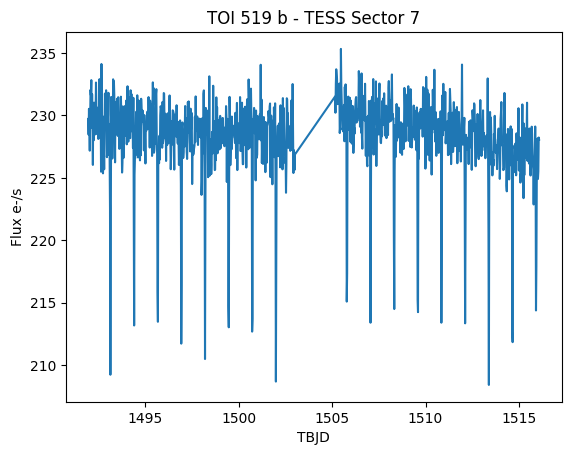

In [32]:
# get the time and psf flux data
tglc_time = tglc_data['time'][good_flags]
tglc_flux = tglc_data['psf_flux'][good_flags]

# set up the plot, add some labels
plt.plot(tglc_time, tglc_flux)
plt.title('TOI 519 b - TESS Sector 7')
plt.xlabel('TBJD')
plt.ylabel('Flux e-/s')

The exoplanet transit is quite clear in this data!

### Calculating Photometric Precision
We'll loosely borrow the strategy for calculating precision from the original [TGLC Paper](https://ui.adsabs.harvard.edu/abs/2023AJ....165...71H/abstract), specifically the strategy described on page 10. Equation 5 relates the precision to `D`, the flux difference between adjacent fluxes:
$$\text{precision}=\frac{1.48}{\sqrt 2} \text{median(|D|)}$$

We can write a function for this!

In [27]:
# input the flux as an array
def precision(lc_flux):
    # subtracting offset arrays gives us the adjacent flux differences
    flux_diff = lc_flux[1:]-lc_flux[:-1]
    return 1.48/np.sqrt(2)*np.nanmedian(np.abs(flux_diff))

Let's use this function to calculate the photometric precision of our flux. By converting first to normalized flux, we can write the precision as a percent; this will be useful to us later on.

**Note**: the paper calls for a weighted average of the PSF and aperture flux. For simplicity, we are not doing this, but it will impact our results!

In [28]:
# normalize the flux
tglc_flux_norm = tglc_flux/np.nanmean(tglc_flux)

# calculate precision, convert to percent
precision(tglc_flux_norm)*100

np.float64(0.7289321895131258)

Our precision is thus 0.729%.

## Comparing to SPOC Processing


The [Science Processing Operations Center (SPOC)](https://ui.adsabs.harvard.edu/abs/2016SPIE.9913E..3EJ/abstract) produces the official TESS mission light curves. Although these light curves are great for their intended purpose, they don't typically reach the levels of photometric precision of TGLC.

Let's repeat our steps from before, but this time use the SPOC data. One caveat here is that SPOC data are separated over many files: there are light curves, target pixel files, validation reports, and more. In order to get a single result (the lightcurve file) from `get_cloud_uris`, we'll need to pass a value to `filter_products`. For this example, `"description":"Light curves"` will return our desired result.

In [24]:
# modify our query for SPOC; add new filter for light curves
spoc_uri = Observations.get_cloud_uris(target_name="218795833",
                                   provenance_name='SPOC',
                                   sequence_number=[7],
                                   filter_products = {"description":"Light curves"}
                                  )
# print info, load in the data
with fits.open(spoc_uri[0], fsspec_kwargs={"anon":True}) as f:
    f.info()
    spoc_data = f[1].data

Filename: <class 's3fs.core.S3File'>
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      44   ()      
  1  LIGHTCURVE    1 BinTableHDU    167   17612R x 20C   [D, E, J, E, E, E, E, E, E, J, D, E, D, E, D, E, D, E, E, E]   
  2  APERTURE      1 ImageHDU        49   (11, 11)   int32   


Notice that this file is structured differently from the TGLC file; it has a secondary aperture HDU. This contains information on which pixels were used for simple aperture photometry.

If we normalize this data, we can calculate the photometric precision and compare with our earlier result.

In [29]:
# get the time values, we'll use this later
spoc_time = spoc_data["TIME"]

# get the flux, compute the normalized flux
spoc_flux = spoc_data["PDCSAP_FLUX"]
spoc_flux_norm = spoc_flux/np.nanmean(spoc_flux)

# calculate precision
precision(spoc_flux_norm)*100

np.float64(2.9111159540703797)

The precision for SPOC processing is 2.911%, compared to the much tighter 0.729% from TGLC. This is reflective of how much better TGLC performs with faint stars in crowded fields!

The high precision becomes even more obvious if we plot the data together:

Text(0, 0.5, 'Normalized flux')

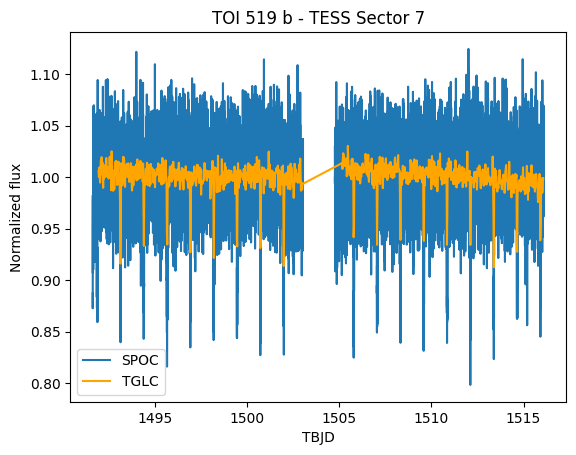

In [38]:
plt.plot(spoc_time, spoc_flux_norm)
plt.plot(tglc_time, tglc_flux_norm, c='orange')

plt.legend(["SPOC", "TGLC"])
plt.title('TOI 519 b - TESS Sector 7')
plt.xlabel('TBJD')
plt.ylabel('Normalized flux')

TGLC, in orange, has a much smaller scatter in the data points. You might find this reduced noise useful when looking at particularly dim stars!

## Additional Resources
- [MAST HLSP Search Form](https://mast.stsci.edu/hlsp/#/)
- [TGLC Paper](https://ui.adsabs.harvard.edu/abs/2023AJ....165...71H/abstract)

## About this Notebook

If you have comments or questions on this notebook, please contact us through the Archive Help Desk e-mail at archive@stsci.edu. If you spot any errors, open an issue on the [tike_content repository](https://github.com/spacetelescope/tike_content).

**Authors:** Thomas Dutkiewicz, Te Han <br>
**Keywords:** TIKE, AWS, TESS <br>
**Last Updated:** Mar 2025 <br>

[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 